In [61]:
import torch
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x
  
  def predict(self, x):
    with torch.no_grad():
      x = self.forward(x)
      return torch.argmax(x, 1)

In [68]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random

# 设置全局随机种子
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)

transform = transforms.Compose([
    transforms.RandomRotation(12),      # 随机旋转
    # transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移
    # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # 随机裁剪和缩放
    transforms.ToTensor()
])

# 加载训练数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)


# 定义训练数据加载器
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)

In [69]:
model = Net()
# weights = torch.ones(10)
# weights[5] = 2.0  # 为数字5赋予更高的权重
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if (i + 1) % 100 == 0:
      print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
            % (epoch + 1, epochs, i + 1, len(train_dataset) // 64, loss.item()))

Epoch [1/10], Iter [100/937] Loss: 0.4516
Epoch [1/10], Iter [200/937] Loss: 0.4657
Epoch [1/10], Iter [300/937] Loss: 0.4818
Epoch [1/10], Iter [400/937] Loss: 0.2874
Epoch [1/10], Iter [500/937] Loss: 0.2593
Epoch [1/10], Iter [600/937] Loss: 0.2482
Epoch [1/10], Iter [700/937] Loss: 0.1383
Epoch [1/10], Iter [800/937] Loss: 0.1910
Epoch [1/10], Iter [900/937] Loss: 0.1141
Epoch [2/10], Iter [100/937] Loss: 0.2351
Epoch [2/10], Iter [200/937] Loss: 0.3916
Epoch [2/10], Iter [300/937] Loss: 0.0967
Epoch [2/10], Iter [400/937] Loss: 0.0629
Epoch [2/10], Iter [500/937] Loss: 0.0801
Epoch [2/10], Iter [600/937] Loss: 0.1345
Epoch [2/10], Iter [700/937] Loss: 0.0519
Epoch [2/10], Iter [800/937] Loss: 0.2404
Epoch [2/10], Iter [900/937] Loss: 0.2005
Epoch [3/10], Iter [100/937] Loss: 0.1783
Epoch [3/10], Iter [200/937] Loss: 0.0824
Epoch [3/10], Iter [300/937] Loss: 0.0699
Epoch [3/10], Iter [400/937] Loss: 0.1364
Epoch [3/10], Iter [500/937] Loss: 0.1664
Epoch [3/10], Iter [600/937] Loss:

In [41]:
# 保存后加载模型
torch.save(model.state_dict(), 'model_five_2.0.pth')
# net = Net()
# net.load_state_dict(torch.load('model.pth'))

{0: 8, 1: 2, 2: 26, 3: 22, 4: 20, 5: 24, 6: 12, 7: 16, 8: 19, 9: 30}
error-count: 179
Accuracy of the network on the 10000 test images: 98.21%


<BarContainer object of 10 artists>

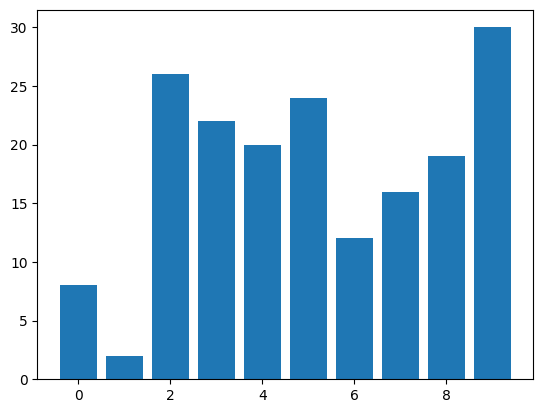

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from PIL import Image
import os

# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

# 测试模型
model.eval()  # 切换到评估模式
with torch.no_grad():
  correct = 0
  total = 0
  """ 统计每个数字的错误次数 """
  error_count_dict = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0
  }

  for batch_index, (images, labels) in enumerate( test_loader):
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    error_index = np.where((predicted == labels).numpy() ==  False)[0]
    for index in error_index:
      error_count_dict[labels[index].item()] += 1
      img = images[index].squeeze().numpy() * 255
      img = Image.fromarray(img.astype('uint8'))
      img_dir = os.path.join(f'./misclassified_images/{labels[index]}')
      if not os.path.exists(img_dir):
        os.makedirs(img_dir)
      img.save(os.path.join(
          img_dir, f'{predicted[index]}_batch{batch_index}_index{index}.png'))
      
pprint(error_count_dict)
print('error-count:', sum(error_count_dict.values()))
print('Accuracy of the network on the 10000 test images: {:.2f}%'.format(100 * correct / total))

# 将每个数字的错误次数绘制为柱状图
plt.bar(error_count_dict.keys(), error_count_dict.values())